# version 1 


+ 1.读取训练集和测试集数据进行预处理
+ 2.训练逻辑回归模型
+ 3.保存模型
+ 4.读取基因数据（基因数据不全，经过预处理大概16000个）
+ 5.定义特征计算函数(继续优化)
+ 6.封装预测函数（输入需要预测的trf序列进行特征计算）
+ 7.调用保存的模型进行预测
+ 8.输出靶标基因并写入csv文件中

+ 修改（增加预测参数，选择靶基因的结合区：3' or 5' or cds）


# 模型训练部分

In [ ]:
# 加载数据预处理
#upload data and package
import pandas as pd
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

trf_train_data = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\train_data_3.csv")
trf_test_data = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\test_data_3.csv")



In [ ]:
#设置训练集和测试集数据
train_data = trf_train_data[trf_train_data.columns[9:16]]
train_data = np.array(train_data).tolist()

test_data = trf_test_data[trf_test_data.columns[9:16]]
test_data = np.array(test_data).tolist()

In [ ]:
#设置标签数据
train_data_label = np.array(trf_train_data).tolist()
train_data_label = [i[16] for i in train_data_label]

test_data_label = np.array(trf_test_data).tolist()
test_data_label = [i[16] for i in test_data_label]

In [ ]:
X_train = train_data
X_test = test_data
y_train = train_data_label
y_test = test_data_label

In [ ]:
#使用逻辑回归模型(0.1)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,shuffle=True, random_state=0)
#正则化系数C = 1时(可调节参数C)
logreg = LogisticRegression(C = 0.001).fit(X_train, y_train)


print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))
print("The feature weight: {}".format(logreg.coef_))

# 模型预测部分

## 1.保存训练好的模型

## 2.定义特征计算函数

## 3. 设置模型预测参数

In [ ]:
#保存模型
import joblib
joblib.dump(logreg,"E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg.pkl")

In [ ]:
#读取基因列表
gene_list = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\unique_gene.csv")
gene_list = gene_list.iloc[:,1:5]

In [ ]:
#定义特征计算函数

#1.创建一个trf序列的列表
def create(trf):
    seq = [trf]
    trf_seq = pd.DataFrame(seq*16606)
    trf_seq.columns = ["trf_seq"]
    return trf_seq

#计算AU含量
def AU_contant(trf_feature):
    AU_list = pd.DataFrame([0]*len(trf_feature))
    AU_list.columns = ["AU_contant"]
    for i in range(len(trf_feature)):
        upscore = 0
        downscore = 0
        for j in range(30):
            if(trf_feature.iloc[i,2][j] == "A" or trf_feature.iloc[i,2][j] == "T"):
                upscore += 1/(j+1)
            if(trf_feature.iloc[i,3][j] == "A" or trf_feature.iloc[i,3][j] == "T"):
                downscore += 1/(j+1)
        AU_list.iloc[i,0] = (upscore + downscore)/2
    trf_feature = pd.concat([trf_feature,AU_list],axis = 1)
    return trf_feature

#看该位点是否匹配
def ispaired(nt):
    if nt == "A":
        return "T"
    if nt == "T":
        return "A"
    if nt == "G":
        return "C"
    if nt == "C":
        return "G"
    else:
        return ""

# 确定结合区位置
def bind_loc(trf_feature):
    start_loc = pd.DataFrame([0]*len(trf_feature))
    start_loc.columns = ["start_loc"]
    end_loc = pd.DataFrame([0]*len(trf_feature))
    end_loc.columns = ["end_loc"]
    for i in range(len(trf_feature)):
        seq = trf_feature.iloc[i,0][0]
        for j in range(len(trf_feature.iloc[i,2])):
            if ispaired(seq) == trf_feature.iloc[i,2][j]:
                start_loc.iloc[i,0] = j
                end_loc.iloc[i,0] = j + len(trf_feature.iloc[i,0])
                break
    trf_feature = pd.concat([trf_feature,start_loc],axis = 1)
    trf_feature = pd.concat([trf_feature,end_loc],axis = 1)
    return trf_feature


#统计结合位点数    
def bind_num(trf_feature):
    count_paired = pd.DataFrame([0]*len(trf_feature))
    count_paired.columns = ["count_paired"]
    for i in range(len(trf_feature)):
        count_num = 0
        for j in range(min(len(trf_feature.iloc[i,0]),len(trf_feature.iloc[i,2])-trf_feature.iloc[i,6])):
            if ispaired(trf_feature.iloc[i,0][j]) == trf_feature.iloc[i,2][trf_feature.iloc[i,6]+j]:
                count_num += 1
        count_paired.iloc[i,0] = count_num
    trf_feature = pd.concat([trf_feature,count_paired],axis = 1)
    return trf_feature

#计算字符串中最长的连续字符数
def maxDup(strs):
    n=len(strs)
    maxlen=1
    length=1
    maxstr=[]
    for i in range(n-1): 
        if strs[i]==strs[i+1]:
            length+=1
            maxstr.append(strs[i+1])
            if length>maxlen:
                maxlen=length
        else:
            length=1
    return maxlen


#计算结合区的长度
def bind_length(trf_feature):
    max_length = pd.DataFrame([0]*len(trf_feature))
    max_length.columns = ["max_length"]
    pos_longest = pd.DataFrame([0]*len(trf_feature))
    pos_longest.columns = ["pos_longest"]
    for i in range(len(trf_feature)):
        seq = ""
        for j in range(min(len(trf_feature.iloc[i,0]),len(trf_feature.iloc[i,2])-trf_feature.iloc[i,6])):
            if ispaired(trf_feature.iloc[i,0][j]) == trf_feature.iloc[i,2][trf_feature.iloc[i,6]+j]:
                seq += "T"
            else:
                seq += str(j)
        max_length.iloc[i,0] = maxDup(seq)
        pos_longest.iloc[i,0] = len(seq)
    trf_feature = pd.concat([trf_feature,max_length],axis = 1)
    trf_feature = pd.concat([trf_feature,pos_longest],axis = 1)
    return trf_feature
        
#计算3'区的结合位点数
def three_prime(trf_feature):
    three_prime = pd.DataFrame([0]*len(trf_feature))
    three_prime.columns = ["three_prime"]
    for i in range(len(trf_feature)):
        count_num = 0
        for j in range(min(7,len(trf_feature.iloc[i,2])-trf_feature.iloc[i,6])):
            if ispaired(trf_feature.iloc[i,0][j]) == trf_feature.iloc[i,2][trf_feature.iloc[i,6]+j]:
                count_num += 1
        three_prime.iloc[i,0] = count_num
    trf_feature = pd.concat([trf_feature,three_prime],axis = 1)
    return trf_feature
    
#输出trf特征列表   
def feature_calculation(trf_seq,trf_list):
    trf = create(trf_seq)
    trf_feature = pd.concat([trf,trf_list],axis = 1)
    trf_feature = AU_contant(trf_feature)
    trf_feature = bind_loc(trf_feature)
    trf_feature = bind_num(trf_feature)
    trf_feature = bind_length(trf_feature)
    trf_feature = three_prime(trf_feature)
    return trf_feature

In [ ]:
#计算特征
trf_sequence = input("please input your trf sequence:")
trf_feature = feature_calculation(trf_sequence, gene_list)

In [ ]:
#获取测试集数据
test_data = trf_feature.iloc[:,5:12]
test_data = np.array(test_data).tolist()

In [ ]:
#调用模型
import joblib
logreg = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg.pkl")
#输入测试集数据进行预测，并输出靶标基因名
result_label = logreg.predict(test_data)
target_gene = []
for i in range(len(result_label)):
    if result_label[i] == 1:
        print(trf_feature.iloc[i,1])
        target_gene.append(trf_feature.iloc[i,1])

In [ ]:
#将靶标基因写入csv文件中
target = pd.DataFrame(columns = ["gene"],data = target_gene)
target.to_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\target_gene.csv")

# version2

+ 训练了三个模型（分别预测trf结合在基因不同区域：3'、5’、cds）

+ 调用模型时传入模型类型的参数进行模型选择调用

+ 通过调用不同模型输出不同结合区的靶基因  

+ 加入参数trf type，访问特征中的trf_type  

+ 加入更多的特征提高模型的预测精度

+ 获取trf序列与其对应**ID的列表**，提供输入ID的预测

+ 输入预测参数（需要预测那一部分）

In [31]:
# 加载数据预处理
#upload data and package
import pandas as pd
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

trf_train_data_3 = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\new_train_data_3.csv")
trf_test_data_3 = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\new_test_data_3.csv")

trf_train_data_5 = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\new_train_data_5.csv")
trf_test_data_5 = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\new_test_data_5.csv")

trf_train_data_cds = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\new_train_data_cds.csv")
trf_test_data_cds = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\new_test_data_cds.csv")

In [32]:
#设置训练集和测试集数据
train_data_3 = trf_train_data_3[trf_train_data_3.columns[9:16]]
train_data_3 = np.array(train_data_3).tolist()

test_data_3 = trf_test_data_3[trf_test_data_3.columns[9:16]]
test_data_3 = np.array(test_data_3).tolist()


train_data_5 = trf_train_data_5[trf_train_data_5.columns[9:16]]
train_data_5 = np.array(train_data_5).tolist()

test_data_5 = trf_test_data_5[trf_test_data_5.columns[9:16]]
test_data_5 = np.array(test_data_5).tolist()


train_data_cds = trf_train_data_cds[trf_train_data_cds.columns[9:16]]
train_data_cds = np.array(train_data_cds).tolist()

test_data_cds = trf_test_data_cds[trf_test_data_cds.columns[9:16]]
test_data_cds = np.array(test_data_cds).tolist()

In [33]:
#设置标签数据
train_data_label = np.array(trf_train_data_3).tolist()
train_data_label = [i[16] for i in train_data_label]

test_data_label = np.array(trf_test_data_3).tolist()
test_data_label = [i[16] for i in test_data_label]

In [34]:
X_train_3 = train_data_3
X_test_3 = test_data_3

X_train_5 = train_data_5
X_test_5 = test_data_5

X_train_cds = train_data_cds
X_test_cds = test_data_cds

y_train = train_data_label
y_test = test_data_label

In [35]:
#使用逻辑回归模型(0.1)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,shuffle=True, random_state=0)
#正则化系数C = 1时(可调节参数C)
logreg_3 = LogisticRegression(C = 1000,solver = "lbfgs",random_state = 10).fit(X_train_3, y_train)
logreg_5 = LogisticRegression(C = 1000,solver = "lbfgs",random_state = 10).fit(X_train_5, y_train)
logreg_cds = LogisticRegression(C = 1000,solver = "lbfgs",random_state = 10).fit(X_train_cds, y_train)


print("logreg_3 Training set score: {:.3f}".format(logreg_3.score(X_train_3, y_train)))
print("logreg_3 Test set score: {:.3f}".format(logreg_3.score(X_test_3, y_test)))
print("logreg_3 The feature weight: {}".format(logreg_3.coef_))

print("logreg_5 Training set score: {:.3f}".format(logreg_5.score(X_train_5, y_train)))
print("logreg_5 Test set score: {:.3f}".format(logreg_5.score(X_test_5, y_test)))
print("logreg_5 The feature weight: {}".format(logreg_5.coef_))


print("logreg_cds Training set score: {:.3f}".format(logreg_cds.score(X_train_cds, y_train)))
print("logreg_cds Test set score: {:.3f}".format(logreg_cds.score(X_test_cds, y_test)))
print("logreg_cds The feature weight: {}".format(logreg_cds.coef_))

logreg_3 Training set score: 0.713
logreg_3 Test set score: 0.739
logreg_3 The feature weight: [[ 0.01373819  0.2736169   0.0309369  -0.27337108 -0.04949721  0.02923627
   0.68122989]]
logreg_5 Training set score: 0.698
logreg_5 Test set score: 0.775
logreg_5 The feature weight: [[-0.25868377  0.32767925 -0.02572717 -0.03151193 -0.00780255  0.00227678
  -0.01451713]]
logreg_cds Training set score: 0.547
logreg_cds Test set score: 0.511
logreg_cds The feature weight: [[-0.62012659  0.01198933 -0.00725674  0.03545903  0.00441907 -0.00519419
  -0.02059396]]


In [36]:
from sklearn.metrics import roc_auc_score
logreg3_auc = roc_auc_score(y_test, logreg_3.predict_proba(X_test_3)[:,1])
print("AUC for Random Forest: {:.3f}".format(logreg3_auc))
logreg5_auc = roc_auc_score(y_test, logreg_5.predict_proba(X_test_5)[:,1])
print("AUC for Random Forest: {:.3f}".format(logreg5_auc))
logregcds_auc = roc_auc_score(y_test, logreg_cds.predict_proba(X_test_cds)[:,1])
print("AUC for Random Forest: {:.3f}".format(logregcds_auc))

AUC for Random Forest: 0.820
AUC for Random Forest: 0.725
AUC for Random Forest: 0.513


AUC for Logreg Model: 0.820


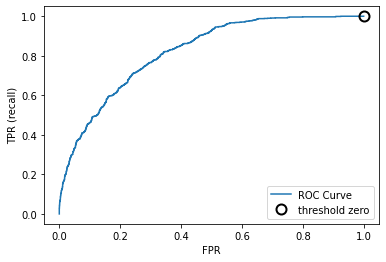

In [38]:
from sklearn.metrics import roc_auc_score
logreg3_auc = roc_auc_score(y_test, logreg_3.predict_proba(X_test_3)[:,1])
print("AUC for Logreg Model: {:.3f}".format(logreg3_auc))
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg_3.predict_proba(X_test_3)[:,1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

AUC for Random Forest: 0.725


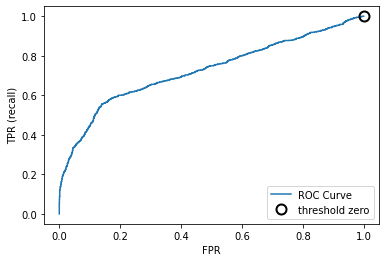

In [39]:
logreg5_auc = roc_auc_score(y_test, logreg_5.predict_proba(X_test_5)[:,1])
print("AUC for Random Forest: {:.3f}".format(logreg5_auc))
fpr, tpr, thresholds = roc_curve(y_test, logreg_5.predict_proba(X_test_5)[:,1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

AUC for Random Forest: 0.513


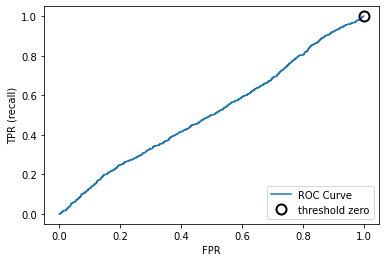

In [40]:
logregcds_auc = roc_auc_score(y_test, logreg_cds.predict_proba(X_test_cds)[:,1])
print("AUC for Random Forest: {:.3f}".format(logregcds_auc))
fpr, tpr, thresholds = roc_curve(y_test, logreg_cds.predict_proba(X_test_cds)[:,1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [41]:
#保存模型
import joblib
joblib.dump(logreg_3,"E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_3.pkl")

joblib.dump(logreg_5,"E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_5.pkl")

joblib.dump(logreg_cds,"E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_cds.pkl")


['E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_cds.pkl']

In [39]:
#读取基因列表
gene_list = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\unique_gene.csv")
gene_list = gene_list.iloc[:,1:5]

In [40]:
#定义特征计算函数

#1.创建一个trf序列的列表
def create(trf,gene_list):
    seq = [trf]
    trf_seq = pd.DataFrame(seq*len(gene_list))
    trf_seq.columns = ["trf_seq"]
    return trf_seq

#计算AU含量
def AU_contant(trf_feature):
    AU_list = pd.DataFrame([0]*len(trf_feature))
    AU_list.columns = ["AU_contant"]
    for i in range(len(trf_feature)):
        upscore = 0
        downscore = 0
        for j in range(30):
            if(trf_feature.iloc[i,2][j] == "A" or trf_feature.iloc[i,2][j] == "T"):
                upscore += 1/(j+1)
            if(trf_feature.iloc[i,3][j] == "A" or trf_feature.iloc[i,3][j] == "T"):
                downscore += 1/(j+1)
        AU_list.iloc[i,0] = (upscore + downscore)/2
    trf_feature = pd.concat([trf_feature,AU_list],axis = 1)
    return trf_feature

#看该位点是否匹配
def ispaired(nt):
    if nt == "A":
        return "T"
    if nt == "T":
        return "A"
    if nt == "G":
        return "C"
    if nt == "C":
        return "G"
    else:
        return ""

# 确定结合区位置
def bind_loc(trf_feature,index):
    start_loc = pd.DataFrame([0]*len(trf_feature))
    start_loc.columns = ["start_loc"]
    end_loc = pd.DataFrame([0]*len(trf_feature))
    end_loc.columns = ["end_loc"]
    for i in range(len(trf_feature)):
        seq = trf_feature.iloc[i,0][0]
        for j in range(len(trf_feature.iloc[i,index+1])):
            if ispaired(seq) == trf_feature.iloc[i,index+1][j]:
                start_loc.iloc[i,0] = j
                end_loc.iloc[i,0] = j + len(trf_feature.iloc[i,0])
                break
    trf_feature = pd.concat([trf_feature,start_loc],axis = 1)
    trf_feature = pd.concat([trf_feature,end_loc],axis = 1)
    return trf_feature


#统计结合位点数    
def bind_num(trf_feature,index):
    count_paired = pd.DataFrame([0]*len(trf_feature))
    count_paired.columns = ["count_paired"]
    for i in range(len(trf_feature)):
        count_num = 0
        for j in range(min(len(trf_feature.iloc[i,0]),len(trf_feature.iloc[i,index+1])-trf_feature.iloc[i,6])):
            if ispaired(trf_feature.iloc[i,0][j]) == trf_feature.iloc[i,index+1][trf_feature.iloc[i,6]+j]:
                count_num += 1
        count_paired.iloc[i,0] = count_num
    trf_feature = pd.concat([trf_feature,count_paired],axis = 1)
    return trf_feature

#计算字符串中最长的连续字符数
def maxDup(strs):
    n=len(strs)
    maxlen=1
    length=1
    maxstr=[]
    for i in range(n-1): 
        if strs[i]==strs[i+1]:
            length+=1
            maxstr.append(strs[i+1])
            if length>maxlen:
                maxlen=length
        else:
            length=1
    return maxlen


#计算结合区的长度
def bind_length(trf_feature,index):
    max_length = pd.DataFrame([0]*len(trf_feature))
    max_length.columns = ["max_length"]
    pos_longest = pd.DataFrame([0]*len(trf_feature))
    pos_longest.columns = ["pos_longest"]
    for i in range(len(trf_feature)):
        seq = ""
        for j in range(min(len(trf_feature.iloc[i,0]),len(trf_feature.iloc[i,index+1])-trf_feature.iloc[i,6])):
            if ispaired(trf_feature.iloc[i,0][j]) == trf_feature.iloc[i,index+1][trf_feature.iloc[i,6]+j]:
                seq += "T"
            else:
                seq += str(j)
        max_length.iloc[i,0] = maxDup(seq)
        pos_longest.iloc[i,0] = len(seq)
    trf_feature = pd.concat([trf_feature,max_length],axis = 1)
    trf_feature = pd.concat([trf_feature,pos_longest],axis = 1)
    return trf_feature
        
#计算3'区的结合位点数
def three_prime(trf_feature):
    three_prime = pd.DataFrame([0]*len(trf_feature))
    three_prime.columns = ["three_prime"]
    for i in range(len(trf_feature)):
        count_num = 0
        for j in range(min(7,len(trf_feature.iloc[i,2])-trf_feature.iloc[i,6])):
            if ispaired(trf_feature.iloc[i,0][j]) == trf_feature.iloc[i,2][trf_feature.iloc[i,6]+j]:
                count_num += 1
        three_prime.iloc[i,0] = count_num
    trf_feature = pd.concat([trf_feature,three_prime],axis = 1)
    return trf_feature
    
#输出trf特征列表   
def feature_calculation(trf_seq,trf_list,index):
    trf = create(trf_seq,trf_list)
    trf_feature = pd.concat([trf,trf_list],axis = 1)
    trf_feature = AU_contant(trf_feature)
    trf_feature = bind_loc(trf_feature,index)
    trf_feature = bind_num(trf_feature,index)
    trf_feature = bind_length(trf_feature,index)
    trf_feature = three_prime(trf_feature)
    return trf_feature

In [15]:
#计算特征(先输入要预测的trf序列，)
trf_sequence = input("please input your trf sequence:")
index = int(input("please input the type of bind region:"))
trf_feature = feature_calculation(trf_sequence, gene_list,index)

please input your trf sequence:ATCCAGGTGCCCCCTCCA
please input the type of bind region:3


In [16]:
#获取测试集数据
test_data = trf_feature.iloc[:,5:12]
test_data = np.array(test_data).tolist()

In [17]:
#调用模型
import joblib
logreg_3 = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_3.pkl")
logreg_5 = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_5.pkl")
logreg_cds = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_cds.pkl")
#输入测试集数据进行预测，并输出靶标基因名
if index == 1:
    result_label = logreg_3.predict(test_data)
if index == 2:
    result_label = logreg_5.predict(test_data)
if index == 3:
    result_label = logreg_cds.predict(test_data)

target_gene = []
for i in range(len(result_label)):
    if result_label[i] == 1:
        #print(trf_feature.iloc[i,1])
        target_gene.append(trf_feature.iloc[i,1])

In [18]:
#将靶标基因写入csv文件中
target = pd.DataFrame(columns = ["gene"],data = target_gene)
target.to_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\target_gene3.csv")

# 测试代码部分

In [20]:
# 加载数据预处理
#upload data and package
import pandas as pd
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

trf_train_data_5 = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\new_train_data_5.csv")
trf_test_data_5 = pd.read_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\new_test_data_5.csv")

#设置训练集和测试集数据
train_data_5 = trf_train_data_5[trf_train_data_5.columns[9:16]]
train_data_5 = np.array(train_data_5).tolist()

test_data_5 = trf_test_data_5[trf_test_data_5.columns[9:16]]
test_data_5 = np.array(test_data_5).tolist()

In [21]:
#设置标签数据
train_data_label = np.array(trf_train_data_5).tolist()
train_data_label = [i[16] for i in train_data_label]

test_data_label = np.array(trf_test_data_5).tolist()
test_data_label = [i[16] for i in test_data_label]

X_train_5 = train_data_5
X_test_5 = test_data_5
y_train = train_data_label
y_test = test_data_label

In [22]:
#使用逻辑回归模型(0.1)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,shuffle=True, random_state=0)
#正则化系数C = 1时(可调节参数C)
logreg_5 = LogisticRegression(C = 0.001,solver = "lbfgs",random_state = 100).fit(X_train_5, y_train)

print("logreg_3 Training set score: {:.3f}".format(logreg_5.score(X_train_5, y_train)))
print("logreg_3 Test set score: {:.3f}".format(logreg_5.score(X_test_5, y_test)))
print("logreg_3 The feature weight: {}".format(logreg_5.coef_))

logreg_3 Training set score: 0.696
logreg_3 Test set score: 0.772
logreg_3 The feature weight: [[-0.13115749  0.31611789 -0.02282006 -0.03218836 -0.0012191   0.00144906
  -0.00941328]]


# 多层感知机模型的表现结果

In [42]:
#多层感知机
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_3, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_3, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_3, y_test)))

D:\yjy\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy on training set: 0.83
Accuracy on test set: 0.83


AUC for Random Forest: 0.923


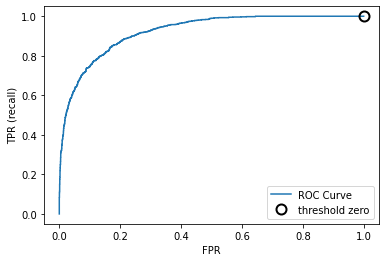

In [43]:
from sklearn.metrics import roc_auc_score
mlp_auc = roc_auc_score(y_test, mlp.predict_proba(X_test_3)[:,1])
print("AUC for Random Forest: {:.3f}".format(mlp_auc))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test_3)[:,1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

AUC for Random Forest: 0.727


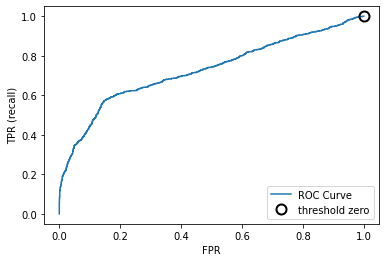

In [23]:
from sklearn.metrics import roc_auc_score
logreg5_auc = roc_auc_score(y_test, logreg_5.predict_proba(X_test_5)[:,1])
print("AUC for Random Forest: {:.3f}".format(logreg5_auc))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg_5.predict_proba(X_test_5)[:,1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

# 评价指标

+ a:真阳性 b:假阳性 c:假阴性 d:真阴性

+ PPV：阳性预测值 a/(a+b)



In [ ]:
#输出模型测试数据的指标数据


In [2]:
import joblib
logreg_3 = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_3.pkl")
logreg_5 = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_5.pkl")
logreg_cds = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_cds.pkl")

In [6]:
print("The 3'model feature weight: {}".format(logreg_3.coef_))

The 3'model feature weight: [[-0.27364661  0.00758203 -0.00074106  0.00289397  0.01080048 -0.00191381
  -0.03828901]]


In [7]:
print("The 5' model feature weight: {}".format(logreg_5.coef_))

The 5' model feature weight: [[-0.25724275  0.01541082 -0.006221    0.02890959 -0.02306304 -0.00137002
  -0.01695497]]


In [8]:
print("The cds model feature weight: {}".format(logreg_cds.coef_))

The cds model feature weight: [[-0.27744316  0.01470373 -0.00667913  0.02300122  0.00409262 -0.00332068
  -0.00563413]]


# 特征计算

+ 7mer-m1 seed:计算trf序列的seed和其互补的seed序列，看gene序列中是否具有该互补seed序列

+ binding energy:



# 湿实验验证数据部分

## 1.湿实验的trf序列数据以及预测出的结果（模型靶基因/湿实验靶基因）

+ 1.ACCCCACTCCTGGTACCA

+ 2.TCAAATCTCGGTGGAACCTCCA(**494/1131**)

+ 3.ACCCCACTCCTGGTACCA

+ 4.GTCTCTGTGGCGCAATGGAC(**113/1784**)

+ 5.GCATTGGTGGTTCAGTGGTAGAATTCTT(**1/113**)



## 2.问题

+ 为什么会有这么多靶基因，几千个（logFC = 2的截断标准下）

+ 有的序列数据中的基因ID号不能转换成symbol号，无法进行预测

In [41]:
#计算特征(先输入要预测的trf序列，)
trf_sequence = input("please input your trf sequence:")
index = int(input("please input the type of bind region:"))
trf_feature1 = feature_calculation(trf_sequence, gene_list,index)

please input your trf sequence:ACCCCACTCCTGGTACCA
please input the type of bind region:1


In [42]:
#计算特征(先输入要预测的trf序列，)
trf_sequence = input("please input your trf sequence:")
index = int(input("please input the type of bind region:"))
trf_feature2 = feature_calculation(trf_sequence, gene_list,index)

please input your trf sequence:TCAAATCTCGGTGGAACCTCCA
please input the type of bind region:1


In [43]:
#计算特征(先输入要预测的trf序列，)
trf_sequence = input("please input your trf sequence:")
index = int(input("please input the type of bind region:"))
trf_feature3 = feature_calculation(trf_sequence, gene_list,index)

please input your trf sequence:ACCCCACTCCTGGTACCA
please input the type of bind region:1


In [44]:
#计算特征(先输入要预测的trf序列，)
trf_sequence = input("please input your trf sequence:")
index = int(input("please input the type of bind region:"))
trf_feature4 = feature_calculation(trf_sequence, gene_list,index)

please input your trf sequence:GTCTCTGTGGCGCAATGGAC
please input the type of bind region:1


In [46]:
# 计算特征(先输入要预测的trf序列，)
trf_sequence = input("please input your trf sequence:")
index = int(input("please input the type of bind region:"))
trf_feature5 = feature_calculation(trf_sequence, gene_list,index)

please input your trf sequence:GCATTGGTGGTTCAGTGGTAGAATTCTT
please input the type of bind region:1


In [47]:
#获取测试集数据
test_data1 = trf_feature1.iloc[:,5:12]
test_data1 = np.array(test_data1).tolist()

#获取测试集数据
test_data2 = trf_feature2.iloc[:,5:12]
test_data2 = np.array(test_data2).tolist()


#获取测试集数据
test_data3 = trf_feature3.iloc[:,5:12]
test_data3 = np.array(test_data3).tolist()


#获取测试集数据
test_data4 = trf_feature4.iloc[:,5:12]
test_data4 = np.array(test_data4).tolist()

#获取测试集数据
test_data5 = trf_feature5.iloc[:,5:12]
test_data5 = np.array(test_data5).tolist()

In [48]:
#调用模型
import joblib
logreg_3 = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_3.pkl")
logreg_5 = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_5.pkl")
logreg_cds = joblib.load("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\logreg_cds.pkl")
#输入测试集数据进行预测，并输出靶标基因名
if index == 1:
    result_label1 = logreg_3.predict(test_data1)
if index == 2:
    result_label1 = logreg_5.predict(test_data1)
if index == 3:
    result_label1 = logreg_cds.predict(test_data1)

target_gene1 = []
for i in range(len(result_label1)):
    if result_label1[i] == 1:
        #print(trf_feature.iloc[i,1])
        target_gene1.append(trf_feature1.iloc[i,1])
        
        
if index == 1:
    result_label2 = logreg_3.predict(test_data2)
if index == 2:
    result_label2 = logreg_5.predict(test_data2)
if index == 3:
    result_label2 = logreg_cds.predict(test_data2)

target_gene2 = []
for i in range(len(result_label2)):
    if result_label2[i] == 1:
        #print(trf_feature.iloc[i,1])
        target_gene2.append(trf_feature2.iloc[i,1])
        
        
        
if index == 1:
    result_label3 = logreg_3.predict(test_data3)
if index == 2:
    result_label3 = logreg_5.predict(test_data3)
if index == 3:
    result_label3 = logreg_cds.predict(test_data3)

target_gene3 = []
for i in range(len(result_label3)):
    if result_label3[i] == 1:
        #print(trf_feature.iloc[i,1])
        target_gene3.append(trf_feature3.iloc[i,1])
        
        
if index == 1:
    result_label4 = logreg_3.predict(test_data4)
if index == 2:
    result_label4 = logreg_5.predict(test_data4)
if index == 3:
    result_label4 = logreg_cds.predict(test_data4)

target_gene4 = []
for i in range(len(result_label4)):
    if result_label4[i] == 1:
        #print(trf_feature.iloc[i,1])
        target_gene4.append(trf_feature4.iloc[i,1])
        
        
if index == 1:
    result_label5 = logreg_3.predict(test_data5)
if index == 2:
    result_label5 = logreg_5.predict(test_data5)
if index == 3:
    result_label5 = logreg_cds.predict(test_data5)

target_gene5 = []
for i in range(len(result_label5)):
    if result_label5[i] == 1:
        #print(trf_feature.iloc[i,1])
        target_gene5.append(trf_feature5.iloc[i,1])

In [49]:
#将靶标基因写入csv文件中
target1 = pd.DataFrame(columns = ["gene"],data = target_gene1)
target1.to_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\target1.csv")

#将靶标基因写入csv文件中
target2 = pd.DataFrame(columns = ["gene"],data = target_gene2)
target2.to_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\target2.csv")


#将靶标基因写入csv文件中
target3 = pd.DataFrame(columns = ["gene"],data = target_gene3)
target3.to_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\target3.csv")


#将靶标基因写入csv文件中
target4 = pd.DataFrame(columns = ["gene"],data = target_gene4)
target4.to_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\target4.csv")


#将靶标基因写入csv文件中
target5 = pd.DataFrame(columns = ["gene"],data = target_gene5)
target5.to_csv("E:\\Windows-SSD\\Program Files (x86)\\Common Files\\Designer\\tRF_prediction\\data\\target5.csv")